--- Data Loaded ---
Total samples: 216
Class distribution:
type
Premise              103
Claim                 69
Non-Argumentative     44
Name: count, dtype: int64
--------------------
Training set size: 172
Testing set size: 44
--------------------
🚀 Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



✅ Hyperparameter tuning complete.

--- Best Parameters Found ---
{'clf__C': 100, 'clf__class_weight': None, 'clf__penalty': 'l1', 'clf__solver': 'saga', 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}

Best cross-validation score (f1_weighted):
0.7659
--------------------

--- Classification Report (on Test Set) ---
                   precision    recall  f1-score   support

            Claim       0.71      0.86      0.77        14
Non-Argumentative       1.00      0.67      0.80         9
          Premise       0.81      0.81      0.81        21

         accuracy                           0.80        44
        macro avg       0.84      0.78      0.79        44
     weighted avg       0.82      0.80      0.80        44



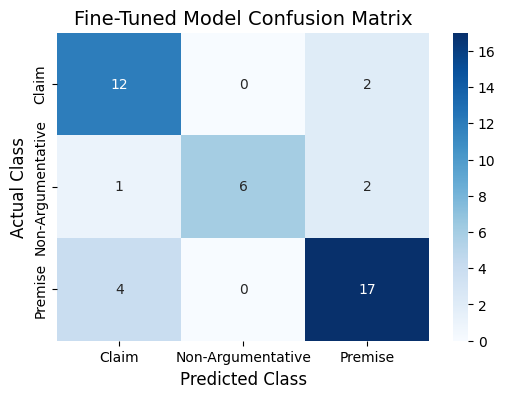

In [39]:
# Step 1: Import Required Libraries
import pandas as pd
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Often useful, good to have

# Step 2: Load and Prepare the Dataset
# IMPORTANT: This script assumes you have a file named 'training_data.json'
# inside a folder named 'resources'.
# The file path is 'resources/training_data.json'.

# --- FIX APPLIED HERE ---
# Added encoding='utf-8' to handle special characters in the JSON file.
# This resolves the UnicodeDecodeError.
with open('resources/training_data.json', 'r', encoding='utf-8') as f:
    training_data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(training_data['training_data'])

# Define features (X) and target (y)
X = df["text"]
y = df["type"]

print("--- Data Loaded ---")
print(f"Total samples: {len(df)}")
print("Class distribution:")
print(df['type'].value_counts())
print("-" * 20)


# Step 3: Split Data into Training and Testing Sets
# This is crucial for evaluating the model on data it has never seen before.
# We use stratify=y to ensure class proportions are the same in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # Using a 20% test split
    random_state=42,   # Ensures the split is the same every time you run the code
    stratify=y         # Recommended for classification to maintain class balance
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print("-" * 20)


# Step 4: Build the Model Pipeline and Define Hyperparameter Grid
# A Pipeline chains the vectorizer and the classifier together.
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(random_state=42))
])

# Define the grid of parameters to search over for fine-tuning.
# This grid tests different configurations to find the best-performing one.
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],              # Test unigrams vs. unigrams & bigrams
    'tfidf__max_df': [0.8, 0.9, 1.0],                   # Ignore words that are too frequent
    'tfidf__min_df': [1, 2],                            # Ignore words that are too rare
    'clf__solver': ['liblinear', 'saga'],               # Solvers that work well with L1/L2 penalties
    'clf__penalty': ['l1', 'l2'],                       # Regularization penalty type
    'clf__C': [0.1, 1, 10, 100],                        # Inverse of regularization strength
    'clf__class_weight': [None, 'balanced']             # Helps with imbalanced classes
}

# Step 5: Perform Grid Search with Cross-Validation
# GridSearchCV automatically tests all parameter combinations using cross-validation.
# We optimize for 'f1_weighted' which is a good metric for imbalanced datasets.
# cv=5 means 5-fold cross-validation. n_jobs=-1 uses all available CPU cores.
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Train the model by fitting it to the training data
print("🚀 Starting hyperparameter tuning with GridSearchCV...")
grid_search.fit(X_train, y_train)


# Step 6: Display the Best Results from the Grid Search
print("\n✅ Hyperparameter tuning complete.")
print("\n--- Best Parameters Found ---")
print(grid_search.best_params_)
print("\nBest cross-validation score (f1_weighted):")
print(f"{grid_search.best_score_:.4f}")
print("-" * 20)


# Step 7: Evaluate the Fine-Tuned Model on the Unseen Test Set
# The best model found by the grid search is stored in `best_estimator_`.
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# --- Generate Final Classification Report ---
# This report shows the precision, recall, and f1-score on the test data.
print("\n--- Classification Report (on Test Set) ---")
print(classification_report(y_test, y_pred))


# --- Generate Final Confusion Matrix ---
# This matrix gives a visual breakdown of correct and incorrect predictions.
conf_matrix = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Using the smaller figsize as requested in the previous prompt.
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=best_model.classes_,
    yticklabels=best_model.classes_
)
plt.title('Fine-Tuned Model Confusion Matrix', fontsize=14)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

In [ ]:
#Multi-label Classification
# Step 1: Install dependencies
%pip install -q sentence-transformers scikit-learn pandas

# Step 2: Import Libraries
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer

# Step 3: Sample Multi-label Data (You can replace this with your real dataset later)
data = {
    "sentence": [
        "According to Section 21, the rule applies.",
        "Because the defendant was not present at the scene.",
        "The court believes the plaintiff acted in good faith.",
        "However, the plaintiff's claim contradicts the evidence.",
        "The judge finally ordered compensation to the tenant."
    ],
    "labels": [
        ["Legal Principle"],
        ["Factual Evidence"],
        ["Factual Evidence", "Judgment"],
        ["Counter-Argument"],
        ["Judgment"]
    ]
}

df = pd.DataFrame(data)

# Step 4: Binarize the multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])

# Step 5: Load Sentence-BERT or LegalBERT embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # You can replace with LegalBERT if needed
X = model.encode(df['sentence'].tolist())

# Step 6: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 7: Train Multi-label Classifier (Logistic Regression with sigmoid)
classifier = MultiOutputClassifier(LogisticRegression())
classifier.fit(X_train, y_train)

# Step 8: Predict and Evaluate
y_pred = classifier.predict(X_test)
print("Classification Report (per label):\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

# Step 9: Predict new sentence
new_sentence = ["The defendant violated the law according to Section 5."]
new_embed = model.encode(new_sentence)
predicted_labels = mlb.inverse_transform(classifier.predict(new_embed))
print("\nPredicted Argument Type(s):", predicted_labels[0])
